**Time Series Analysis Jakarta Stock Exchange Composite and Forecasting using LTSM**

In [38]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

import plotly as plotly
import plotly.io as plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

from tensorflow import keras
from tensorflow.keras.layers import Dense,LSTM,Dropout,Flatten
from tensorflow.keras import Sequential

In [39]:
df = pd.read_csv("./Data Historis Jakarta Stock Exchange Composite.csv")
df

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,18/01/2024,"7.243,47","7.198,85","7.265,65","7.191,15","13,83B","0,59%"
1,17/01/2024,"7.200,63","7.248,01","7.248,04","7.163,65","20,21B","-0,58%"
2,16/01/2024,"7.242,79","7.214,21","7.266,74","7.214,21","13,03B","0,26%"
3,15/01/2024,"7.224,00","7.254,04","7.276,62","7.207,31","13,30B","-0,24%"
4,12/01/2024,"7.241,14","7.242,37","7.270,74","7.207,04","15,22B","0,29%"
...,...,...,...,...,...,...,...
983,08/01/2020,"6.225,69","6.248,44","6.250,12","6.218,13","4,46B","-0,85%"
984,07/01/2020,"6.279,35","6.272,22","6.284,89","6.246,13","3,94B","0,35%"
985,06/01/2020,"6.257,40","6.293,50","6.300,44","6.252,63","4,14B","-1,04%"
986,03/01/2020,"6.323,47","6.306,19","6.323,47","6.287,71","4,46B","0,63%"


In [40]:
print(df.dtypes)
print("")

df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d/%m/%Y')

numeric_columns = ['Terakhir', 'Pembukaan', 'Tertinggi', 'Terendah']
df[numeric_columns] = df[numeric_columns].apply(lambda x: x.str.replace('.', '', regex=False).str.replace(',', '.', regex=False)).astype(float)
df['Vol.'] = df['Vol.'].str.replace(',', '').str.replace('B', '').astype(float) * 1e9

df['Perubahan%'] = df['Perubahan%'].astype(str)

print("After Convert: \n")
print(df.dtypes)

Tanggal       object
Terakhir      object
Pembukaan     object
Tertinggi     object
Terendah      object
Vol.          object
Perubahan%    object
dtype: object

After Convert: 

Tanggal       datetime64[ns]
Terakhir             float64
Pembukaan            float64
Tertinggi            float64
Terendah             float64
Vol.                 float64
Perubahan%            object
dtype: object


In [41]:
df = df.sort_values(by=["Tanggal"])
df.reset_index(drop=True)

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,2020-01-02,6283.58,6313.13,6317.01,6263.68,3.300000e+11,"-0,25%"
1,2020-01-03,6323.47,6306.19,6323.47,6287.71,4.460000e+11,"0,63%"
2,2020-01-06,6257.40,6293.50,6300.44,6252.63,4.140000e+11,"-1,04%"
3,2020-01-07,6279.35,6272.22,6284.89,6246.13,3.940000e+11,"0,35%"
4,2020-01-08,6225.69,6248.44,6250.12,6218.13,4.460000e+11,"-0,85%"
...,...,...,...,...,...,...,...
983,2024-01-12,7241.14,7242.37,7270.74,7207.04,1.522000e+12,"0,29%"
984,2024-01-15,7224.00,7254.04,7276.62,7207.31,1.330000e+12,"-0,24%"
985,2024-01-16,7242.79,7214.21,7266.74,7214.21,1.303000e+12,"0,26%"
986,2024-01-17,7200.63,7248.01,7248.04,7163.65,2.021000e+12,"-0,58%"


In [42]:
print("First Trade:")
print(df.head(5))

print("\nLast Trade:")
print(df.tail(5))


First Trade:
       Tanggal  Terakhir  Pembukaan  Tertinggi  Terendah          Vol.  \
987 2020-01-02   6283.58    6313.13    6317.01   6263.68  3.300000e+11   
986 2020-01-03   6323.47    6306.19    6323.47   6287.71  4.460000e+11   
985 2020-01-06   6257.40    6293.50    6300.44   6252.63  4.140000e+11   
984 2020-01-07   6279.35    6272.22    6284.89   6246.13  3.940000e+11   
983 2020-01-08   6225.69    6248.44    6250.12   6218.13  4.460000e+11   

    Perubahan%  
987     -0,25%  
986      0,63%  
985     -1,04%  
984      0,35%  
983     -0,85%  

Last Trade:
     Tanggal  Terakhir  Pembukaan  Tertinggi  Terendah          Vol.  \
4 2024-01-12   7241.14    7242.37    7270.74   7207.04  1.522000e+12   
3 2024-01-15   7224.00    7254.04    7276.62   7207.31  1.330000e+12   
2 2024-01-16   7242.79    7214.21    7266.74   7214.21  1.303000e+12   
1 2024-01-17   7200.63    7248.01    7248.04   7163.65  2.021000e+12   
0 2024-01-18   7243.47    7198.85    7265.65   7191.15  1.383000e+1

Here u can notice that our first trading date is "2020-01-02" but with 33B stocks traded and final trading date is "2024-01-18" but with 13.83B stocks traded.

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 988 entries, 987 to 0
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Tanggal     988 non-null    datetime64[ns]
 1   Terakhir    988 non-null    float64       
 2   Pembukaan   988 non-null    float64       
 3   Tertinggi   988 non-null    float64       
 4   Terendah    988 non-null    float64       
 5   Vol.        986 non-null    float64       
 6   Perubahan%  988 non-null    object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 61.8+ KB


In [44]:
# Fill NaN with 0
df['Vol.'] = df["Vol."].fillna(0)

<Axes: >

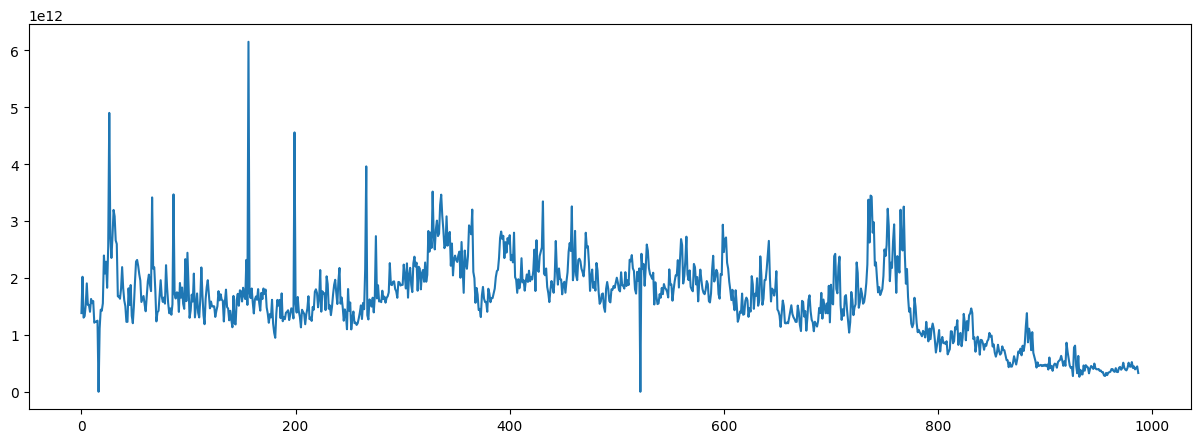

In [45]:
df['Vol.'].plot(figsize=(15,5))

<Axes: >

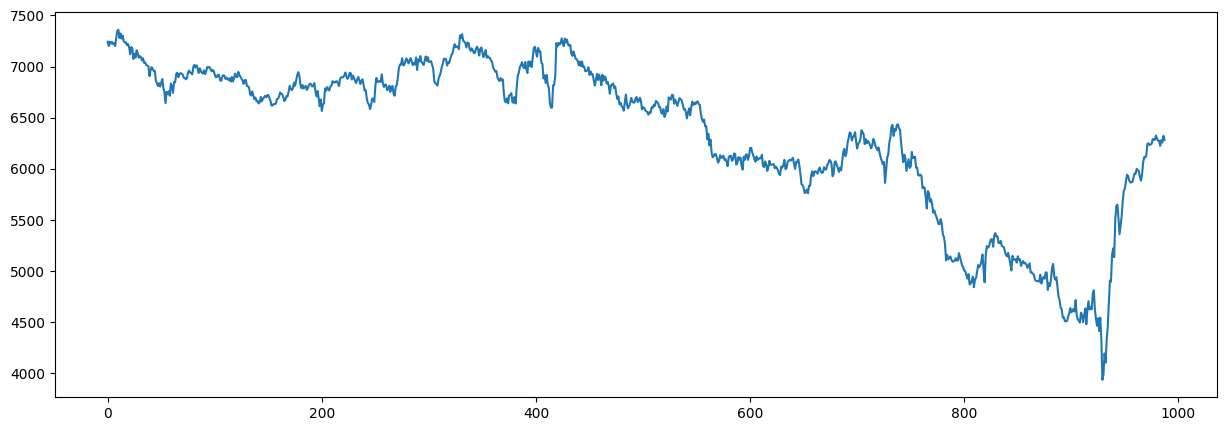

In [46]:
df['Terakhir'].plot(figsize=(15,5))

C:\Users\alexander.santiago\AppData\Local\Temp\ipykernel_4024\1991088523.py:1: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


c:\Users\alexander.santiago\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\alexander.santiago\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='Terakhir', ylabel='Density'>

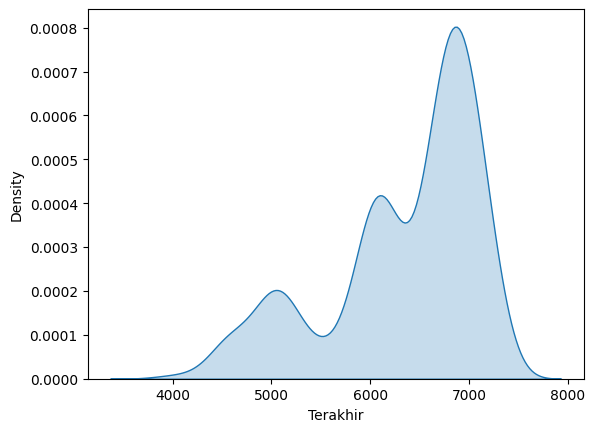

In [47]:
sns.kdeplot(df['Terakhir'], shade=True)

In [48]:
df['Kembali'] = (df['Terakhir']-df['Pembukaan'])/df['Pembukaan']
stocks_data = df.copy()

df.sample(5)

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%,Kembali
974,2020-01-21,6238.15,6252.00,6257.88,6226.06,4.190000e+11,"-0,11%",-0.002215
30,2023-12-05,7100.85,7093.12,7114.58,7048.57,3.196000e+12,"0,10%",0.001090
958,2020-02-12,5913.08,5957.06,5962.35,5895.72,2.930000e+11,"-0,69%",-0.007383
527,2021-11-22,6723.39,6731.52,6754.46,6690.82,2.181000e+12,"0,05%",-0.001208
920,2020-04-07,4778.64,4811.83,4975.54,4721.72,8.620000e+11,"-0,69%",-0.006898


In [49]:
fig = px.line(df,x="Tanggal",y="Terakhir",title="Closing Price: Range Slider and Selectors")
fig.update_xaxes(rangeslider_visible=True,rangeselector=dict(
    buttons=list([
        dict(count=1,label="1m",step="month",stepmode="backward"),
        dict(count=6,label="6m",step="month",stepmode="backward"),
        dict(count=1,label="YTD",step="year",stepmode="todate"),
        dict(count=1,label="1y",step="year",stepmode="backward"),
        dict(step="all")
])))

In [50]:
fig = px.line(df,x="Tanggal",y="Kembali",title="Returns : Range Slider and Selectors")
fig.update_xaxes(rangeslider_visible=True,rangeselector=dict(
    buttons=list([
        dict(count=1,label="1m",step="month",stepmode="backward"),
        dict(count=6,label="6m",step="month",stepmode="backward"),
        dict(count=1,label="YTD",step="year",stepmode="todate"),
        dict(count=1,label="1y",step="year",stepmode="backward"),
        dict(step="all")
])))

In [51]:
fig = go.Figure(data=[go.Candlestick(x=df['Tanggal'],
                                    open=df['Pembukaan'],
                                    high=df['Tertinggi'],
                                    low=df['Terendah'],
                                    close=df['Terakhir'])])
fig.show()

**Technical Indicators**

Indicators are best way to visualize a stock pattern.
This article will focus on a list of technical indicators that are widely used by professionals and scholars, and those that I believe are most beneficial in automated trading. The list of indicators are:

- Simple Moving Average (Fast and Slow)

- Exponential Moving Average (Fast and Slow)

- Relative Strength Index (RSI)

- Moving Average Convergence Divergence (MACD)

**Simple Moving Average**

- Simple Moving Average is one of the most common technical indicators.
- SMA calculates the average of prices over a given interval of time and is used to determine the trend of the stock.
- As defined above, I will create a slow SMA (SMA_15) and a fast SMA (SMA_5).
- Here these numerical values represents the time interval like 15days.

In [52]:
df['SMA_5'] = df['Terakhir'].rolling(5).mean().shift()
df['SMA_15'] = df['Terakhir'].rolling(15).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Tanggal,y=df.SMA_5,name='SMA_5'))
fig.add_trace(go.Scatter(x=df.Tanggal,y=df.SMA_15,name='SMA_15'))
fig.add_trace(go.Scatter(x=df.Tanggal,y=df.Terakhir,name='Close', opacity=0.3))
fig.show()

**Exponential Moving Average (EMA)**
- An exponential moving average (EMA) is a type of moving average (MA) that places a greater weight and significance on the most recent data points.
- Basically what it means is that the newer stock price data has a higher weightage/significance on the price than older day

In [53]:
df['EMA_5'] = df['Terakhir'].ewm(5).mean().shift()
df['EMA_15'] = df['Terakhir'].ewm(15).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Tanggal,y=df.EMA_5,name='EMA_5'))
fig.add_trace(go.Scatter(x=df.Tanggal,y=df.EMA_15,name='EMA_15'))
fig.add_trace(go.Scatter(x=df.Tanggal,y=df.Terakhir,name='Close', opacity=0.3))
fig.show()

**Combining SMA5 & EMA5**

In [54]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Tanggal,y=df.SMA_5,name='SMA_5'))
fig.add_trace(go.Scatter(x=df.Tanggal,y=df.EMA_5,name='EMA_5'))
fig.add_trace(go.Scatter(x=df.Tanggal,y=df.Terakhir,name='Close', opacity=0.3))
fig.show()


**Relative Strength Index (RSI)**

- A momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock.

- If the RSI value is >70 then the stock is overbought and if more than 30 then its oversold.

- The basic formula is: **RSI = 100 – [ 100 / ( 1 + (Average of Upward Price Change / Average of Downward Price Change ) ) ]**

In [55]:
def RSI(df,n=14):
    close = df['Terakhir']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp<0]=0
    pricesDown[pricesDown>0]=0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp/rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = RSI(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.Tanggal,y=df.RSI,name='RSI'))
fig.show()

**Moving Average Convergence Divergence (MACD)**
- MACD uses two exponentially moving averages and creates a trend analysis based on their convergence or divergence.
- The most commonly used MACD slow and fast signals are based on 26 days and 12 days respectively.
- The MACD is calculated by subtracting the 26-period exponential moving average (EMA) from the 12-period EMA.
- Similar to RSI, MACD triggers technical signals when it crosses above (to buy) or below (to sell) its signal line.

In [56]:
df['EMA_12'] = pd.Series(df['Terakhir'].ewm(span=12).mean())
df['EMA_26'] = pd.Series(df['Terakhir'].ewm(span=26).mean())
df['MACD'] = pd.Series(df['EMA_12'] - df['EMA_26'])
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9,min_periods=9).mean())

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Tanggal,y=df.MACD,name='MACD'))
fig.add_trace(go.Scatter(x=df.Tanggal,y=df.MACD_signal,name='MACD_signal'))
fig.show()

**Forecasting**

Split the data
Important Note on Cross Validation

To measure the performance of our forecasting model, We typically want to split the time series into a training period and a validation period. This is called fixed partitioning.

Now we are going to create an LTSM model and will train it with the closing price of the stock on the train data. So let us split the data into train and test set and visualize it.

- train: Data from 2020 to 31st December, 2022.

- valid: Data from 1st January, 2023 to 2024.



**LSTM**

Long Short-Term Memory (LSTM) models are a type of recurrent neural network capable of learning sequences of observations. This makes them a deep learning network well suited for time series forecasting.

In [57]:
df_train = stocks_data[stocks_data.Tanggal < "2023"]
df_valid = stocks_data[stocks_data.Tanggal >= "2023"]

In [58]:
train = df_train['Terakhir'].values
test = df_valid['Terakhir'].values

In [59]:
training_values = np.reshape(train,(len(train),1))
scaler = MinMaxScaler()
training_values = scaler.fit_transform(training_values)

x_train = training_values[0:len(training_values)-1]
y_train = training_values[1:len(training_values)]
x_train = np.reshape(x_train,(len(x_train),1,1))

In [60]:
model = Sequential()
model.add(LSTM(128,return_sequences=True,input_shape=(None,1)))
model.add(LSTM(64,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mean_squared_error')

model.fit(x_train,y_train,epochs=25,batch_size=8)

Epoch 1/25
92/92 [==============================] - 5s 9ms/step - loss: 0.0713
Epoch 2/25
92/92 [==============================] - 1s 8ms/step - loss: 0.0024
Epoch 3/25
92/92 [==============================] - 1s 8ms/step - loss: 5.2723e-04
Epoch 4/25
92/92 [==============================] - 0s 5ms/step - loss: 5.0132e-04
Epoch 5/25
92/92 [==============================] - 0s 5ms/step - loss: 4.8706e-04
Epoch 6/25
92/92 [==============================] - 0s 5ms/step - loss: 5.0097e-04
Epoch 7/25
92/92 [==============================] - 1s 10ms/step - loss: 4.7568e-04
Epoch 8/25
92/92 [==============================] - 0s 5ms/step - loss: 4.4071e-04
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 4.8684e-04
Epoch 10/25
92/92 [==============================] - 1s 6ms/step - loss: 4.6231e-04
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - loss: 4.8486e-04
Epoch 12/25
92/92 [==============================] - 1s 7ms/step - loss: 4.6076e-04
Epoch 13

assign test and predicted values + reshaping + converting back from scaler

In [61]:
test_values = np.reshape(test, (len(test), 1))
test_values = scaler.transform(test_values)
test_values = np.reshape(test_values, (len(test_values), 1, 1))
predicted_price = model.predict(test_values)
predicted_price = scaler.inverse_transform(predicted_price)
predicted_price=np.squeeze(predicted_price)

8/8 [==============================] - 1s 9ms/step


In [62]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_valid.Tanggal,y=df_valid.Terakhir,name='Close'))
fig.add_trace(go.Scatter(x=df_valid.Tanggal,y=predicted_price,name='Forecast_LSTM'))
fig.show()

In [63]:
# evaluate forecasts
mse_lstm = mean_squared_error(test, predicted_price)
print('Test MSE: %.3f' % mse_lstm)

Test MSE: 64.362
